# HDA - Project 3: TASK A
## Classification of Modes of Locomotion
This first cell contains the parameters that can be tuned for code execution:
- subject: select the subject on which to test the model, between [1,4];
- folder: directory name where '.mat' files are stored;
- label_col: column of features to be selected to perform activity detection, between [0,6];
- window_size: parameter that sets the length of temporal windows on which to perform the convolution;
- stride: step length to chose the next window.

In [9]:
subject = 2
folder = "./data/reduced_nozero/"
trim_zeros = False
label_col = 0     # default for task A
window_size = 15
stride = 15

In [10]:
import utils
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from keras.optimizers import Adam

In [11]:
# import all sessions for a subject
(data1, data2, data3, data4, data5, data6) = utils.loadData(subject, folder=folder)

# create training set and test set
X_train = np.concatenate((data1['features'],\
                          data2['features'],\
                          data3['features'],\
                          data6['features']), axis=0)

Y_train = np.concatenate((data1['labels'][:,label_col],\
                          data2['labels'][:,label_col],\
                          data3['labels'][:,label_col],\
                          data6['labels'][:,label_col]), axis=0)

X_test = np.concatenate((data4['features'],\
                         data5['features']), axis=0)

Y_test = np.concatenate((data4['labels'][:,label_col],\
                         data5['labels'][:,label_col]))

features = X_test.shape[1]

if trim_zeros:
    mask = np.where(Y_train == 0)[0]
    Y_train = np.delete(Y_train,mask)
    X_train = np.delete(X_train,mask,axis=0)

    mask = np.where(Y_test == 0)[0]
    Y_test = np.delete(Y_test,mask)
    X_test = np.delete(X_test,mask,axis=0)

print("\nTraining samples: ", X_train.shape[0],\
      "\nTest samples:      ", X_test.shape[0],\
      "\nFeatures:            ", features)


Session shapes:
ADL1:   (34928, 55)
ADL2:   (23108, 55)
ADL3:   (26659, 55)
ADL4:   (25517, 55)
ADL5:   (22969, 55)
Drill:  (47264, 55)

Training samples:  131959 
Test samples:       48486 
Features:             55


In [12]:
# decision to overcome the problem of entire missing columns
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# features normalization
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# switch to one hot encoded labels
onehot_encoder = OneHotEncoder(sparse=False,categorical_features='all')

Y_train_oh = onehot_encoder.fit_transform(Y_train.reshape(-1, 1))
Y_test_oh = onehot_encoder.fit_transform(Y_test.reshape(-1, 1))
print("\nClasses in training set: ", Y_train_oh.shape[1],\
      "\nClasses in test set:     ", Y_test_oh.shape[1])


Classes in training set:  4 
Classes in test set:      4


Preparation of data in a input-suitable form

In [19]:
X_train_s, Y_temp = utils.prepareData(X_train, Y_train_oh, window_size, stride, shuffle=False)
print(Y_temp)
Y_train_s = onehot_encoder.fit_transform(Y_temp.reshape(-1, 1))
print(Y_train_s)
X_test_s, Y_temp_s = utils.prepareData(X_test, Y_test_oh, window_size, stride, shuffle=False)
Y_test_s = onehot_encoder.fit_transform(Y_temp_s.reshape(-1, 1))


Features have shape:  (8796, 15, 55) 
Labels have shape:    (8796, 4) 
Fraction of labels:   [0. 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]

Features have shape:  (3231, 15, 55) 
Labels have shape:    (3231, 4) 
Fraction of labels:   [0. 0. 0. 0.]


In [14]:
classes = np.max((Y_train_oh.shape[1], Y_test_oh.shape[1]))

# Classification Performances

## 1D Convolutional Neural Network

In [15]:
model_unidim = utils.Model1D((window_size, features), classes)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 15, 18)            4968      
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 18)            72        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 15, 18)            0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 8, 18)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 8, 36)             4572      
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 36)             144       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 36)             0         
__________

In [16]:
opt = Adam(lr=0.01)
model_unidim.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])

model_unidim.fit(x = X_train_s, y = Y_train_s, epochs = 5, batch_size = 128, validation_data=(X_test_s, Y_test_s))

Train on 8796 samples, validate on 3231 samples
Epoch 1/5
8796/8796 [==============================] - 3s 318us/step - loss: 1.0871 - acc: 0.7677 - val_loss: 0.4751 - val_acc: 0.8465
Epoch 2/5
8796/8796 [==============================] - 2s 211us/step - loss: 0.5326 - acc: 0.8337 - val_loss: 0.6120 - val_acc: 0.7691
Epoch 3/5
8796/8796 [==============================] - 2s 201us/step - loss: 0.4769 - acc: 0.8398 - val_loss: 0.7634 - val_acc: 0.7762
Epoch 4/5
8796/8796 [==============================] - 2s 201us/step - loss: 0.4241 - acc: 0.8557 - val_loss: 0.8624 - val_acc: 0.7734
Epoch 5/5
8796/8796 [==============================] - 2s 217us/step - loss: 0.4003 - acc: 0.8629 - val_loss: 0.8432 - val_acc: 0.7803


In [17]:
# predict labels
Y_pred_s = model_unidim.predict(X_test_s)

F1-measure:  0.7780606027580127
AUC w.r. to each class:  {0: 0.8529459927389068, 1: 0.9715186150176387, 2: 0.9232744632631988, 3: 0.9991704886760289}


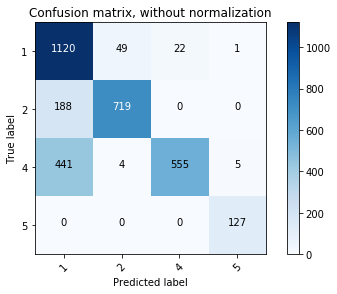

In [18]:
# print results
#reverse the one-hot encoder procedure
Y_test_hard = np.argmax(Y_test_s, axis=1)
Y_pred_hard = np.argmax(Y_pred_s, axis=1)

print("F1-measure: ", utils.f1_score(Y_test_hard, Y_pred_hard, average='weighted'))
print("AUC w.r. to each class: ", utils.AUC(Y_test_s, Y_pred_s, classes))

# Compute and plot confusion matrix
cnf_matrix = utils.confusion_matrix(Y_test_hard, Y_pred_hard)
np.set_printoptions(precision=2)

plt.figure()
utils.plot_confusion_matrix(cnf_matrix,classes = [1,2,4,5],
                      title='Confusion matrix, without normalization')